In [1]:
import numpy as np
import cupy as cp
from einops import rearrange, reduce
from typing import Union, Dict
try:
    cp_array_class = cp.core.core.ndarray
except:
    cp_array_class = cp._core.core.ndarray
Array = Union[np.ndarray, cp_array_class]

In [2]:
class FruitFlyWordEmbedding():

  #model start
    def __init__(self,input: int,output: int,lr: int,k: int) -> None:
        
        #to initialize the model when instance is created
    
        self.input = input
        self.output = output
        self.weights = np.random.rand(output, input)
        self.lr = lr
        self.xp = np
        self.training = True
        self.k = k

    def __call__(self, x: Array, probs: Array) -> None:
        
        #this runs when model instance is called
        
        b = x.shape[0]
        activations = self.xp.inner(self.weights, x)
        out = self.xp.zeros_like(activations)
        out[rearrange(activations.argsort(axis=0)[-self.k:], 'k b -> (b k)'),
            rearrange(self.xp.indices((self.k, b))[1], 'k b -> (b k)')] = 1

        if self.training:
            self._backward(x, probs, activations)

        return rearrange(out, 'd b -> b d')

    def _backward(self, x: Array, probs: Array, activations: Array) -> None:
        
        #Updates weights
        
        assert self.training, "Cannot update weights in eval mode"
        normalized_x = rearrange(x / probs, 'b d -> b () d')
        activations = rearrange(activations == activations.max(axis=0), 'd b -> b d ()')

        normalized_weights = rearrange(self.xp.inner(self.weights, normalized_x), 'd b () -> b d ()')
        self.weights += self.lr * (activations * (normalized_x - normalized_weights * self.weights)).sum(axis=0)
    
  
    def load_state_dict(self, state_dict: Dict[str, Array]) -> None:
        
        #Loads weights

        curr_shape, new_shape = self.weights.shape, state_dict['weights'].shape
        assert curr_shape == new_shape, f"Incorrect size for `weights`. Expected {curr_shape}, got {new_shape}."
        self.weights = state_dict['weights']
        self.to('cpu' if self.xp==np else 'gpu')
    
    def state_dict(self) -> Dict[str, Array]:
        return {'weights': cp.asnumpy(self.weights).copy()}

    def eval(self) -> None:
        self.training = False

    def train(self) -> None:
        self.training = True

    def to(self, device: str) -> None:
        
        #Moves weight array to device to gpu or cpu. defaults to cpu

        if device == 'cpu':
            self.weights = cp.asnumpy(self.weights)
        elif device == 'gpu':
            self.weights = cp.asarray(self.weights)
        else:
            self.weights = cp.asnumpy(self.weights)
        self.xp = cp.get_array_module(self.weights)


In [3]:
def energy_function(weights: Array, x: Array, probs: Array) -> Array:
    #loss function
    xp = cp.get_array_module(weights)
    max_activation_indices = xp.inner(weights, x).argmax(axis=0)
    max_activation_weights = weights[max_activation_indices]
    energy = -xp.inner(max_activation_weights, (x / probs)).diagonal()/xp.sqrt(xp.inner(max_activation_weights, max_activation_weights).diagonal())
    return energy.sum()

Loading dataset

In [4]:
import pandas as pd
import spacy

In [5]:
from tqdm.notebook import tqdm
from collections import Counter, OrderedDict
import cupy as cp
import cupy as xp
from cupyx.scipy.sparse import csr_matrix, vstack
import numpy as np

In [6]:
#start reading pokemon file
df = pd.read_csv('pokemon.csv')
corpus = df.groupby('name').description.apply(' '.join)
corpus.head()

shape: (898,)


name
Abomasnow    They appear when the snow flowers bloom. When ...
Abra         Sleeps 18 hours a day. If it senses danger, it...
Absol        Every time ABSOL appears before people, it is ...
Accelgor     When its body dries out, it weakens. So, to pr...
Aegislash    Generations of kings were attended by these Po...
Name: description, dtype: object

In [7]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
nlp = spacy.load('en_core_web_sm')
#tokenization using spacy

In [9]:
#preprocess data
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess_text(text_data):
    preprocessed_text = []
    for sentence in tqdm(text_data):
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stops)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

def create_token(sentence):
    """
    ignored numbers, stop words and special characters. Splits using spacy
    """
    return [word.lemma_.lower() for word in nlp(sentence) 
          if not word.is_punct and not word.like_num and not word.lemma_.lower() in nlp.Defaults.stop_words]

In [10]:
tokens = []
init_vocabulary_size = 20000
batch_size = 32

# create tokens
for batch_st in tqdm(range(0, len(corpus), batch_size)):
    tokens += create_token(' '.join(corpus.iloc[batch_st:batch_st+batch_size]))

  0%|          | 0/29 [00:00<?, ?it/s]

In [11]:
#using vocab size 20000 for ease of computation
tokens_to_counts = dict(Counter(tokens).most_common(init_vocabulary_size))
total_count = sum(tokens_to_counts.values())

#calculate probabilities p
tokens_to_probabilities = {token : count / total_count for token, count in tokens_to_counts.items()}

In [12]:
vocabulary = list(tokens_to_probabilities.keys())
probabilities = xp.tile(xp.array(list(tokens_to_probabilities.values())), 2)
#final vocab length
N_voc = len(tokens_to_counts)

print(f'vocabulary size: {N_voc}')

vocabulary size: 6564


Prepare training data

In [13]:
def get_token_id(sentence, vocabulary):
    
    #get token from sentence. token_id will be its index from vocabulary created above

    tokens = create_token(sentence)
    token_ids = [vocabulary.index(token) for token in tokens if token in vocabulary]
    return token_ids

In [14]:
def get_training_dataset(token_ids, w_grams, vocabulary_size):
    """
    create w-grams of given size. center word is the target word and rest become context.
    Window is slid along the text corpus and a training vector of size 2Nvoc is generated for each position.
    Target word is one-hot encoded in the target block, and the context words are binary encoded as a bag of words in the context block
    """

    w_grams = min(w_grams, len(token_ids))
    context_idx = w_grams//2
    w_grams = xp.array(np.lib.stride_tricks.sliding_window_view(token_ids, w_grams))
    w_grams[:, context_idx] += vocabulary_size


    train_dataset = xp.zeros((w_grams.shape[0], vocabulary_size*2))
    train_dataset[xp.indices(w_grams.shape)[0], w_grams] = 1

    train_dataset = train_dataset.astype(xp.bool_)

    return train_dataset

In [15]:
w_gram_size = 11

train_dataset = []
for text in tqdm(corpus):
    token_ids = get_token_id(text, vocabulary) #returns index of the word from vocabulary if present
  
    train_dataset.append(csr_matrix(get_training_dataset(token_ids, w_gram_size, len(vocabulary))))
train_dataset = vstack(train_dataset)

  0%|          | 0/898 [00:00<?, ?it/s]

Train dataset

In [16]:
model = FruitFlyWordEmbedding(input = N_voc * 2, output = 400,lr = 1e-6,k = 51)
model.to('gpu')

In [17]:
train_dataset.shape[0]

86574

In [18]:
batch_size = 32

loss = 0
epochs = 10 #change
for epoch in range(epochs):
  
    #shuffle for randomness
    mixed_idxs = xp.random.permutation(train_dataset.shape[0])
    train_dataset = train_dataset[mixed_idxs]
    
    for batch_st in tqdm(range(0, train_dataset.shape[0], batch_size)):
    
        input = train_dataset[batch_st:batch_st+batch_size].toarray()
        model(input, probabilities) #__call__ method triggered

        #calculate loss
        loss += energy_function(model.weights, input, probabilities)
    
        if batch_st//batch_size % 1000 == 999:
            print('epoch', epoch, 'batch', (batch_st//batch_size), 'loss', (loss/(batch_size*1000)))
            loss = 0
        
# print metrics after each epoch
print('epoch:', epoch, 'batch', (batch_st//batch_size), 'loss', (batch_size*((train_dataset.shape[0]//batch_size)%1000)))
loss = 0

  0%|          | 0/2706 [00:00<?, ?it/s]

epoch 0 batch 999 loss -1325.838615939674
epoch 0 batch 1999 loss -3364.044662064323


  0%|          | 0/2706 [00:00<?, ?it/s]

epoch 1 batch 999 loss -20968.283815078667
epoch 1 batch 1999 loss -17694.107153444467


  0%|          | 0/2706 [00:00<?, ?it/s]

epoch 2 batch 999 loss -31522.574240788686
epoch 2 batch 1999 loss -18523.685379430284


  0%|          | 0/2706 [00:00<?, ?it/s]

epoch 3 batch 999 loss -31851.675663992897
epoch 3 batch 1999 loss -18398.404291377832


  0%|          | 0/2706 [00:00<?, ?it/s]

epoch 4 batch 999 loss -32123.95958442797
epoch 4 batch 1999 loss -18548.470625427126


  0%|          | 0/2706 [00:00<?, ?it/s]

epoch 5 batch 999 loss -32075.89803544534
epoch 5 batch 1999 loss -18628.52192503549


  0%|          | 0/2706 [00:00<?, ?it/s]

epoch 6 batch 999 loss -32265.258609313583
epoch 6 batch 1999 loss -18768.17096275549


  0%|          | 0/2706 [00:00<?, ?it/s]

epoch 7 batch 999 loss -32153.656377760024
epoch 7 batch 1999 loss -18732.7452802597


  0%|          | 0/2706 [00:00<?, ?it/s]

epoch 8 batch 999 loss -32253.477496806205
epoch 8 batch 1999 loss -18766.52139833249


  0%|          | 0/2706 [00:00<?, ?it/s]

epoch 9 batch 999 loss -32316.659337170862
epoch 9 batch 1999 loss -18954.471891327845
epoch: 9 batch 2705 loss 22560


In [32]:
loss_list = [-4689.884,-38662.391,-50046.259,-50250.08,-50672.431,-50704.42,-51033.4230,-50886.401,-51019.998,-51271.131]

In [35]:
e = list(range(0,10))

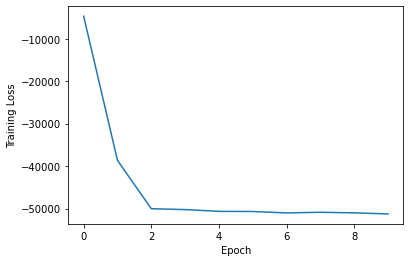

In [41]:
import matplotlib.pyplot as plt
plt.plot(e, loss_list)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

In [19]:
import pickle

# save vocabulary
with open('vocab.pkl', 'wb') as vocab_file:
    pickle.dump(vocabulary, vocab_file)

# save probabilities

with open('prob.npy', 'wb') as prob_file:
    xp.save(prob_file, cp.asnumpy(probabilities))

# save model weights
with open('weights.pkl', 'wb') as file:
    pickle.dump(model.state_dict(), file)

Load pickle files instead of training every time

In [82]:
import pickle

# load vocabulary
with open('vocab.pkl', 'rb') as vocab_file:
    vocabulary = pickle.load(vocab_file)
    vocabulary_size = len(vocabulary)

# load probabilities
with open('prob.npy', 'rb') as prob_file:
    probabilities = xp.load(prob_file)

# tokenization functions and classes
nlp = spacy.load('en_core_web_sm')

def create_tokens_from_text(text):
    """Tokenizes text by:
    - splitting with SpaCy
    - ignoring punctuations, numbers, and stop words
    """
    return [w.lemma_.lower() for w in nlp(text) 
          if not w.is_punct and 
          not w.like_num and 
          not w.lemma_.lower() in nlp.Defaults.stop_words]

# reinstantiate model and load weights
model = FruitFlyWordEmbedding(input = N_voc * 2, output = 400,lr = 1e-6,k = 51)
model.to('gpu')

with open('weights.pkl', 'rb') as file:
    model.load_state_dict(pickle.load(file))

AssertionError: Incorrect size for `weights`. Expected (400, 13128), got (400, 13184).

In [20]:
def create_ohe_for_target(sentence, vocab):
    sentence = (create_token(sentence)+[None])[0]
    id = None if sentence not in vocab else vocab.index(sentence) + len(vocab)
    encoded_input = xp.zeros(len(vocab)*2)
    if id is not None:
        encoded_input[id] = 1
    return encoded_input

In [21]:
stat_embeds = []
for token in tqdm(vocabulary):
    stat_embeds.append(create_ohe_for_target(token, vocabulary))
stat_embeds = xp.stack(stat_embeds)

  0%|          | 0/6564 [00:00<?, ?it/s]

In [22]:
batch_size = 32
model.eval()
static_embeddings = []
for batch_st in tqdm(range(0, stat_embeds.shape[0], batch_size)):
    input = stat_embeds[batch_st:batch_st+batch_size]
    static_embeddings.append(model(input, probabilities))
static_embeddings = xp.concatenate(static_embeddings)

  0%|          | 0/206 [00:00<?, ?it/s]

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

def results(token, top_similar):
  
    token = (create_token(token)+[None])[0]
    id = None if token not in vocabulary else vocabulary.index(token)
    if id is None:
        return {'not present in vocab': 1.0}
  
    input_embedding = create_ohe_for_target(token, vocabulary) #[0,0,...]
    input_embedding = rearrange(input_embedding, 'd -> () d') #[[0,0,....]]

    model.eval()
    embedding = model(input_embedding, probabilities)
    
    similarities = cosine_similarity(cp.asnumpy(embedding), cp.asnumpy(static_embeddings))
    similarities = rearrange(similarities, '() i -> i')

    current_vocabulary = vocabulary
    if id is not None:
        similarities = np.concatenate((similarities[:id], similarities[id+1:]))
        current_vocabulary = current_vocabulary[:id]+current_vocabulary[id+1:]

    top_similar_ids = similarities.argsort(kind='stable')[-top_similar:].tolist()
    
    top_similar_scores = similarities[top_similar_ids]
    
    top_similar_tokens = [current_vocabulary[id] for id in top_similar_ids]
    
    return OrderedDict(zip(top_similar_tokens, top_similar_scores))

In [30]:
fn = results("fire", 10)

inpembedding: [[0. 0. 0. ... 0. 0. 0.]]
embedding: [[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
  0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0.

In [50]:
fn = results("leave", 5)
print(fn)

OrderedDict([('tree', 0.2941176470588235), ('grown', 0.2941176470588235), ('forest', 0.31372549019607837), ('plant', 0.33333333333333326), ('left', 0.9999999999999996)])


In [52]:
fn = results("tree", 5)
print(fn)

OrderedDict([('love', 0.2745098039215686), ('leave', 0.2941176470588235), ('branch', 0.2941176470588235), ('left', 0.2941176470588235), ('touch', 0.3137254901960784)])


In [60]:
fn = results("cold", 10)
print(fn)

OrderedDict([('hidden', 0.2941176470588235), ('stays', 0.2941176470588235), ('ice', 0.31372549019607837), ('fahrenheit', 0.31372549019607837), ('bury', 0.31372549019607837), ('dislike', 0.31372549019607837), ('warm', 0.33333333333333326), ('burrow', 0.33333333333333326), ('temperature', 0.3333333333333333), ('colder', 0.9999999999999997)])


In [56]:
fn = results("trainer", 5)
print(fn)

OrderedDict([('hottest', 0.27450980392156854), ('ability', 0.2745098039215686), ('care', 0.2745098039215686), ('bring', 0.2941176470588235), ('trainers', 0.9999999999999997)])


In [42]:
vocabulary

['pokemon',
 'body',
 'use',
 'prey',
 'tail',
 'live',
 'power',
 'water',
 'like',
 'people',
 'grow',
 'attack',
 'head',
 'foe',
 'fly',
 'eat',
 'shell',
 'wing',
 'long',
 'strong',
 'electricity',
 'time',
 'tree',
 'large',
 'hard',
 'food',
 'night',
 'sea',
 'day',
 'appear',
 'energy',
 'sleep',
 'away',
 'enemy',
 'battle',
 'leave',
 'find',
 'opponent',
 'fire',
 'cause',
 'light',
 'come',
 'eye',
 'small',
 'ground',
 'create',
 'speed',
 'sharp',
 'nest',
 'powerful',
 'form',
 'mountain',
 'sense',
 'air',
 'hide',
 'wave',
 'horn',
 'rock',
 'swim',
 'year',
 'flame',
 'inside',
 'poison',
 'high',
 'store',
 'know',
 'fur',
 'protect',
 'cry',
 'look',
 'love',
 'mouth',
 'leg',
 'arm',
 'deep',
 'run',
 'life',
 'cover',
 'fight',
 'change',
 'sky',
 'place',
 'foot',
 'sound',
 'world',
 'close',
 'flower',
 'ancient',
 'cold',
 'ice',
 'catch',
 'control',
 'fall',
 'big',
 'fast',
 'plant',
 'burn',
 'trainer',
 'turn',
 'land',
 'thing',
 'face',
 'search',
 'k

In [79]:
'abc '*3

'abc abc abc '

In [96]:
sent = str()
lst = []
for k, v in fn.items():
    a = float(v)*10.0
    for i in range(0, int(a)):
#         print('hre')
        lst.append(k)
#     print(k, v)
#     a=((float(v)*1000.0))
#     sent += (k+' ')*int(a)
    

In [97]:
lst

['hidden',
 'hidden',
 'stays',
 'stays',
 'ice',
 'ice',
 'ice',
 'fahrenheit',
 'fahrenheit',
 'fahrenheit',
 'bury',
 'bury',
 'bury',
 'dislike',
 'dislike',
 'dislike',
 'warm',
 'warm',
 'warm',
 'burrow',
 'burrow',
 'burrow',
 'temperature',
 'temperature',
 'temperature',
 'colder',
 'colder',
 'colder',
 'colder',
 'colder',
 'colder',
 'colder',
 'colder',
 'colder']

In [98]:
sent = (' ').join(lst)

In [99]:
sent

'hidden hidden stays stays ice ice ice fahrenheit fahrenheit fahrenheit bury bury bury dislike dislike dislike warm warm warm burrow burrow burrow temperature temperature temperature colder colder colder colder colder colder colder colder colder'

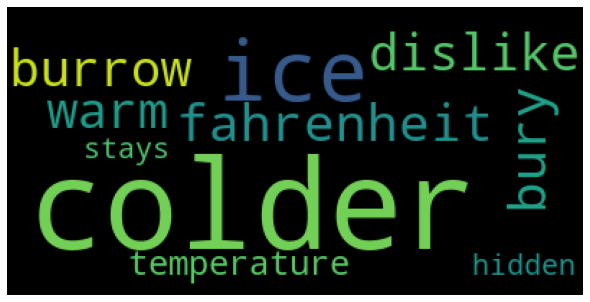

In [101]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(min_font_size = 10).generate(sent)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.savefig('cold_similar_10.png')

In [35]:
def my_create_tokens_from_text(text):
    """Tokenizes text by:
    - splitting with SpaCy
    - ignoring punctuations, numbers, and stop words
    """
    return [w.lemma_.lower() for w in nlp(text) 
          if not w.is_punct and 
          not w.like_num and 
          not w.lemma_.lower() in nlp.Defaults.stop_words]

word2vec_list = list()
for sen in corpus:
    tok = my_create_tokens_from_text(sen)
    word2vec_list.append(tok)

print(word2vec_list)

[['appear', 'snow', 'flower', 'bloom', 'petal', 'fall', 'retreat', 'place', 'unknown', 'pokemon', 'know', 'bring', 'blizzard', 'shake', 'massive', 'body', 'cause', 'whiteout', 'condition', 'live', 'quiet', 'life', 'mountain', 'perpetually', 'cover', 'snow', 'hide', 'whip', 'blizzard', 'blanket', 'wide', 'area', 'snow', 'whip', 'blizzard', 'know', 'ice', 'monster', 'live', 'quiet', 'life', 'mountain', 'perpetually', 'cover', 'snow', 'hide', 'whip', 'blizzard', 'appear', 'snow', 'flower', 'bloom', 'petal', 'fall', 'retreat', 'place', 'unknown', 'blanket', 'wide', 'area', 'snow', 'whip', 'blizzard', 'know', 'ice', 'monster', 'whip', 'blizzard', 'mountain', 'bury', 'snow', 'abominable', 'snowman', 'pack', 'darumaka', 'snover', 'chase', 'swinge', 'sizable', 'arm', 'like', 'hammer'], ['sleep', 'hour', 'day', 'sense', 'danger', 'teleport', 'safety', 'sleep', 'sleep', 'hour', 'day', 'sleep', 'teleport', 'treetop', 'pick', 'eat', 'berry', 'teleport', 'safety', 'asleep', 'wake', 'know', 'panic',

In [37]:
import gzip
import gensim 
import logging

model = gensim.models.Word2Vec (word2vec_list, window=10, min_count=2, workers=10)
hist = model.train(word2vec_list,total_examples=len(word2vec_list),epochs=10)

In [38]:
w1 = "fire"
res = model.wv.most_similar(positive=w1)
print(res)

[('scorch', 0.9406017661094666), ('burn', 0.9341223239898682), ('flame', 0.9322528839111328), ('hyper', 0.9232252240180969), ('smoke', 0.9168869256973267), ('intensely', 0.9152703285217285), ('incinerate', 0.8952817320823669), ('fiery', 0.8798962831497192), ('hunch', 0.8783321380615234), ('flare', 0.8776479363441467)]


In [39]:
for vec in res:
    print(vec)
    break

('scorch', 0.9406017661094666)


In [40]:
from scipy import stats
yardstick = model.wv['fire']
average_distance = 0
for item in res:
#     print(model.wv[item[0]])
    vector_distance = stats.spearmanr(yardstick, model.wv[item[0]])
#     print(vector_distance[0])
    average_distance = average_distance + vector_distance[0]
#     break
    
print(average_distance/10)


0.8897461746174617


In [52]:
fruit_res = []
for k, v in fn.items():
    fruit_res.append((k, v))
    

In [59]:
average_distance = 0
for item in fruit_res:
#     print(item[0])
    vector_distance = stats.spearmanr(yardstick, model.wv[item[0]])
    average_distance = average_distance + vector_distance[0]
    
print(average_distance/10)


KeyError: "Key 'hottest' not present"

In [61]:
static_embeddings[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0.

In [57]:
tokens

['fire']